In [110]:
# Basic libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# TensorFlow and Keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import load_img, img_to_array


### Visualize the Dataset


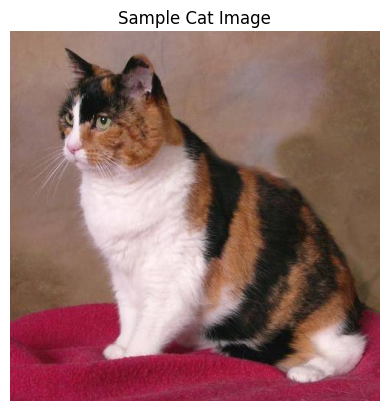

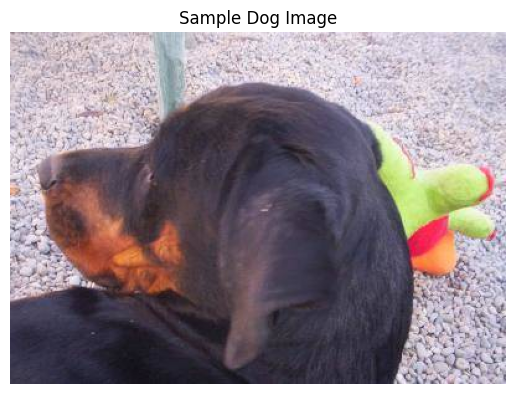

In [111]:
# Define directories
train_dir = '../data/train/'
val_dir = '../data/validation/'
test_dir = '../data/test/unknown/'

# Display a random cat image from the training set
cat_img_path = os.path.join(train_dir, 'cat', random.choice(os.listdir(os.path.join(train_dir, 'cat'))))
cat_img = mpimg.imread(cat_img_path)
plt.imshow(cat_img)
plt.title("Sample Cat Image")
plt.axis('off')
plt.show()

# Display a random dog image from the training set
dog_img_path = os.path.join(train_dir, 'dog', random.choice(os.listdir(os.path.join(train_dir, 'dog'))))
dog_img = mpimg.imread(dog_img_path)
plt.imshow(dog_img)
plt.title("Sample Dog Image")
plt.axis('off')
plt.show()


### Data Preprocessing

In [112]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Only normalization for validation and test sets
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

# Validation generator
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=1,
    class_mode=None,  # No labels for test set
    shuffle=False
)


Found 202 images belonging to 2 classes.
Found 202 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


### Build a CNN Model

In [113]:
# Define CNN architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

### Define Callbacks for Optimization

In [114]:
# Save the best model
checkpoint_callback = ModelCheckpoint(
    filepath='../model/CNN_image_classifier-cat_or_dog.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Stop training if no improvement
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


### Train the model

In [115]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=25,
    callbacks=[checkpoint_callback, early_stopping_callback]
)


Epoch 1/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.4975 - loss: 0.8180
Epoch 1: val_loss improved from inf to 0.69265, saving model to ../model/CNN_image_classifier-cat_or_dog.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 893ms/step - accuracy: 0.5004 - loss: 0.8119 - val_accuracy: 0.4844 - val_loss: 0.6926
Epoch 2/25
1/6 ━━━━━━━━━━━━━━━━━━━━ 2s 563ms/step - accuracy: 0.5000 - loss: 0.7231
Epoch 2: val_loss improved from 0.69265 to 0.69130, saving model to ../model/CNN_image_classifier-cat_or_dog.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - accuracy: 0.5000 - loss: 0.7231 - val_accuracy: 0.5677 - val_loss: 0.6913
Epoch 3/25
1/6 ━━━━━━━━━━━━━━━━━━━━ 3s 736ms/step - accuracy: 0.5312 - loss: 0.6922

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.5062 - loss: 0.6926
Epoch 3: val_loss improved from 0.69130 to 0.69125, saving model to ../model/CNN_image_classifier-cat_or_dog.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5045 - loss: 0.6927 - val_accuracy: 0.5000 - val_loss: 0.6913
Epoch 4/25
1/6 ━━━━━━━━━━━━━━━━━━━━ 2s 571ms/step - accuracy: 0.4375 - loss: 0.7009
Epoch 4: val_loss improved from 0.69125 to 0.69043, saving model to ../model/CNN_image_classifier-cat_or_dog.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 424ms/step - accuracy: 0.4375 - loss: 0.7009 - val_accuracy: 0.5000 - val_loss: 0.6904
Epoch 5/25
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.5309 - loss: 0.6913
Epoch 5: val_loss did not improve from 0.69043
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5290 - loss: 0.6920 - val_accuracy: 0.4896 - val_loss: 0.6921
Epoch 6/25
1/6 ━━━━━━━━━━━━━━━━━━━━ 2s 533ms/step - accuracy: 0.4062 - loss: 0.7094
Epoch 6: val_loss improved from 0.69043 to 0.68947, savin

### Visualize training history

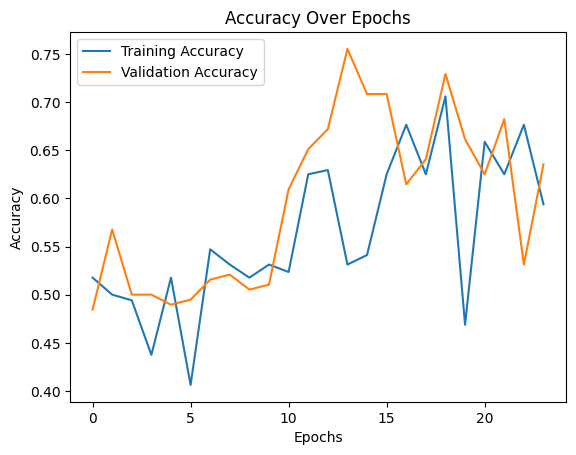

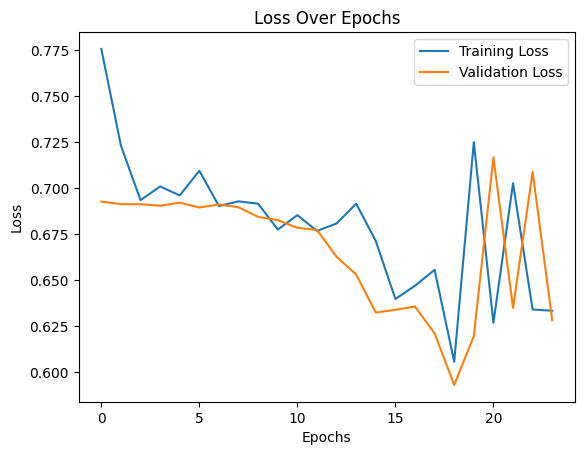

In [116]:
# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Evaluate the model

In [117]:
# Load the best saved model
best_model = load_model('../model/CNN_image_classifier-cat_or_dog.keras')

# Evaluate on validation data
val_loss, val_accuracy = best_model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy:.2f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.7512 - loss: 0.5892
Validation Accuracy: 0.71


### Make prediction on Test Data

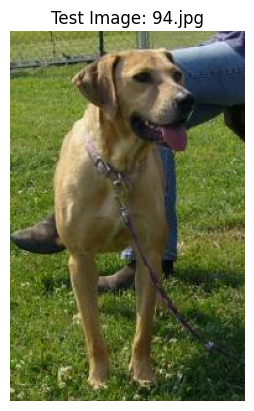

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
The model predicts this is a dog with confidence 0.75


In [128]:
# Randomly select an image from the test set
random_image = random.choice(os.listdir(test_dir))
random_image_path = os.path.join(test_dir, random_image)

# Display the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Test Image: {random_image}")
plt.axis('off')
plt.show()

# Preprocess the image for prediction
img = load_img(random_image_path, target_size=(128, 128))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = best_model.predict(img_array)[0][0]
predicted_label = 'dog' if prediction > 0.5 else 'cat'
print(f"The model predicts this is a {predicted_label} with confidence {prediction:.2f}")
